### Table of Contents

* [I. Putting data into fastText embedding](#chapter1)
   * [1. Loading the FastText model to embedd the data](#section_1_1)
   * [2. Loading the tweets](#section_1_2)
   * [3. Displaying the distribution of tweet's length (usefull for the padding)](#section_1_3)
   * [4. Embedding the tweets with FastText](#section_1_4)
   * [5. Pad the embedded tweets](#section_1_5)
   * [6. Split into training and validating set](#section_1_6)
* [II. Building the LSTM model](#chapter2)
    * [1. Architecture of the LSTM](#section_2_1)
    * [1. Training of the LSTM](#section_2_2)
* [III. Making the predictions for Submission](#chapter3)

In [30]:
import sys

sys.path.insert(1, '/Users/douglasbouchet/M1/ML/ml_project_2_sentwiment/src')

import sklearn
import fasttext
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K
from keras.layers import *
from keras.losses import *
from keras.models import *
from keras.callbacks import *
from keras.activations import *
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from load_utils import load_df

### I. Putting data into fastText embedding <a class="anchor" id="chapter1"></a>

#### 1. Loading the fastText model to embedd data  <a class="anchor" id="section_1_1"></a>

In [31]:
# We assume that you have followed the step of the readme, and that you have put the model at the correct place
model = fasttext.load_model("../data/word_Embeddings/FastText/fasttext_model.bin")

#### 2. Loading the tweets  <a class="anchor" id="section_1_2"></a>

In [32]:
# We load our small dataframe (the training of lstm requires to much time if trained on the full data, and does not provide significant increase of accuracy)
df = load_df(full=False,lemmatize=True)

y = df.positive

#### 3. Displaying the distribution of tweet's length (usefull for the padding)  <a class="anchor" id="section_1_3"></a>

In [33]:
# For each tweet, we record its number of words
tweet_len = {}
for elem in df.tweet: 
    l = len(elem.split(" "))
    old_val = tweet_len.get(l) or 0
    tweet_len[l] = old_val + 1

In [34]:
tweet_len = collections.OrderedDict(sorted(tweet_len.items()))

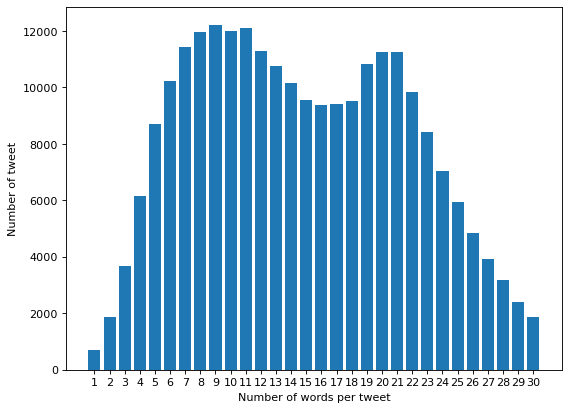

In [35]:
figure(figsize=(8, 6), dpi=80)

plt.xlabel("Number of words per tweet")
plt.ylabel("Number of tweet")
# There are almost no tweet longer than 30 words, so we avoid plotting them for a better visualization
plt.bar(range(len(tweet_len))[0:30], list(tweet_len.values())[0:30], align='center')
plt.xticks(range(len(tweet_len))[0:30], list(tweet_len.keys())[0:30])

plt.show()

#### 4. Embedding the tweet with fastText  <a class="anchor" id="section_1_4"></a>

In [36]:
# For each word of each tweet, we compute its fastText embedding 
embedded = []
for tweet in df.tweet:
    vec = []
    for word in tweet.split(" "):
        # get the embedding of the word
        vec.append(model.get_word_vector(word))
    embedded.append(np.asarray(vec))
embedded = np.asarray(embedded)

/var/folders/2v/f5sm00lj343gkrnlrbwvbls00000gn/T/ipykernel_20007/1244914488.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embedded = np.asarray(embedded)


#### 5. Pad the embedded tweets  <a class="anchor" id="section_1_5"></a>

In [37]:
# We need all our inputs of our LSTM to have same length, that's why we apply padding. 22 is the optimal size (explained in the report). 'pre' is also better
# than 'post'. Using a padding of 22 allows to capture all features of almost all tweets (see figure above).
padded_x = tf.keras.preprocessing.sequence.pad_sequences(
    embedded, maxlen=22, padding="pre", dtype='float32'
)


#### 6. Splitting into training and validating set  <a class="anchor" id="section_1_6"></a>

In [38]:
# We use a valid set of 20% of the total data
x_train, x_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state=26105111)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((196664, 22, 300), (49166, 22, 300), (196664,), (49166,))

In [39]:
# Output of the LSTM will have a sigmoid as activation function, that's why we transform the -1 labels into 0
new_y_train = []
for i,elem in enumerate(y_train):
    if(elem == -1):
        new_y_train.append(0)
    else: 
        new_y_train.append(1)

new_y_test = []
for i,elem in enumerate(y_test):
    if(elem == -1):
        new_y_test.append(0)
    else: 
        new_y_test.append(1)

### II. Building the LSTM model <a class="anchor" id="chapter2"></a>

#### 1. Architecture of the LSTM  <a class="anchor" id="section_2_1"></a>

In [40]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam 

from keras.callbacks import EarlyStopping, TensorBoard

# We declare the architecture of the LSTM.
# To resume what we said in the report:
#  Conv1D capture topics
#  MaxPadding capture most important feature
#  LSTM allow take into account the order of words inside the tweet
#  Dropout help reduce the overfitting
#  Binary classification so 1 output neuron with sigmoid activation function

lstm = Sequential()

lstm.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=(22, 300)))
lstm.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
lstm.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
lstm.add(MaxPooling1D(pool_size=3))

lstm.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))

lstm.add(Dense(512, activation='sigmoid'))
lstm.add(Dropout(0.2))
lstm.add(Dense(512, activation='sigmoid'))
lstm.add(Dropout(0.25))
lstm.add(Dense(512, activation='sigmoid'))
lstm.add(Dropout(0.25))

lstm.add(Dense(1, activation='sigmoid'))

# We used the adam optimizer. Learning rate has been tuned (see report). Use binary_crossentropy and accuracy to correctly measure performances of our network 
lstm.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 22, 32)            28832     
                                                                 
 conv1d_4 (Conv1D)           (None, 22, 32)            3104      
                                                                 
 conv1d_5 (Conv1D)           (None, 22, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             2232320   
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 512)              

/Users/douglasbouchet/anaconda3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### 2. Training of the model  <a class="anchor" id="section_2_2"></a>

In [41]:
# Next we fit LSTM on our training data. Batch size and epochs have been tuned (see report).
# The expected runing time should be ~ TODO (without GPU)
lstm.fit(x_train, pd.Series(new_y_train), batch_size=512, shuffle=True, epochs=5,
         validation_data=(x_test, pd.Series(new_y_test)))

Epoch 1/5
385/385 [==============================] - 354s 901ms/step - loss: 0.4672 - accuracy: 0.7584 - val_loss: 0.3854 - val_accuracy: 0.8184
Epoch 2/5
385/385 [==============================] - 307s 796ms/step - loss: 0.3847 - accuracy: 0.8206 - val_loss: 0.3739 - val_accuracy: 0.8266
Epoch 3/5
385/385 [==============================] - 350s 910ms/step - loss: 0.3692 - accuracy: 0.8288 - val_loss: 0.3641 - val_accuracy: 0.8316
Epoch 4/5
385/385 [==============================] - 338s 878ms/step - loss: 0.3572 - accuracy: 0.8352 - val_loss: 0.3594 - val_accuracy: 0.8343
Epoch 5/5
385/385 [==============================] - 334s 867ms/step - loss: 0.3508 - accuracy: 0.8392 - val_loss: 0.3614 - val_accuracy: 0.8344


### 3. Making the predictions for Submission <a class="anchor" id="chapter_3"></a>

In [42]:
data_test = pd.read_csv('../data/data_submission_preprocessed.csv')

# For each word of each tweet, we compute its fastText embedding 
embedded = []
for tweet in data_test.tweet:
    vec = []
    for word in tweet.split(" "):
        # get the embedding of the word
        vec.append(model.get_word_vector(word))
    embedded.append(np.asarray(vec))
embedded = np.asarray(embedded)

# pad the inputs
padded_x = tf.keras.preprocessing.sequence.pad_sequences(
    embedded, maxlen=22, padding="pre", dtype='float32'
)

# for each tweet, we use the LSTM to predict a label
predictions = lstm(padded_x)

# we replace labels by -1 if it was less than 0.5 else by 1, as we use a sigmoid at the end of the LSTM
res = []
for i,elem in enumerate(predictions):
    if(elem >= 0.5):
        res.append(1)
    else:
        res.append(-1)
#We rename the Id column in order to be accepted in the submission platform
data_test = data_test.rename(columns={'tweet_idx':'Id'})
# We add the prections column
data_test['Prediction'] = res
# We save to a csv file only Id, Prediction columns
data_test[['Id', 'Prediction']].to_csv('../submission.csv', encoding='utf-8', index=False)


/var/folders/2v/f5sm00lj343gkrnlrbwvbls00000gn/T/ipykernel_20007/2783233971.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embedded = np.asarray(embedded)
